### Magics

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

%load_ext watermark
%watermark -a 'Salomon Tetelepta' -d -t -v -p tensorflow,numpy,pandas,matplotlib -g

Salomon Tetelepta 2019-10-10 08:50:02 

CPython 3.7.4
IPython 7.7.0

tensorflow 1.14.0
numpy 1.16.4
pandas 0.25.0
matplotlib 3.1.1
Git hash: faa9866e6260b7f052f9f9463fbd06635b9cbb86


### Imports

In [29]:
import os
import sys

import numpy as np
import pandas as pd
import cv2

import pickle
import random

from pathlib import Path
import matplotlib.pyplot as plt

# sklearn
from sklearn.cluster import KMeans

# scipy
from scipy.optimize import minimize

### Settings

In [30]:
# get project path, and flag if script runs in a file
project_path = Path(os.getcwd(), os.pardir)
output_path = project_path / "output"
model_path = project_path / "models"
results_csv_path = output_path / 'results.csv'

# add project root to pythonpath
sys.path.insert(0, str(project_path / "src"))

# import custom packages
from set_cardgame.dataset import *
from set_cardgame.utils import *

# make results repeatable
seed = 42
random.seed(seed)  # python built-in pseudo-random generator
np.random.seed(seed)  # numpy pseudo-random generator

In [4]:
# number of training images
nr_images = 810
input_shape = (96, 128, 3)

### Load data

In [5]:
# load training and validation data
X_train, y_train, X_val, y_val = load_dataset(nr_images=nr_images)

Found 243 images belonging to 81 classes.
Found 81 images belonging to 81 classes.
X_train.shape: (810, 96, 128, 3)
X_val.shape: (81, 96, 128, 3)
Number of training samples (m_train): 810
Number of validation samples (m_val): 81


### Explore colour space for different images

The SET images are simple coloured symbols. Let's explore how the colours are distributed in the RGB colour space. Each pixel values of the image can be seen as a 3D point in the RGB space (0-255).

I'm specifically interested in how those values change under different lighting conditions.

#### How are colours distributed across the different RGB channels?

In [54]:
# pick some images
img1 = X_val[0]
img2 = X_val[1]
img3 = X_val[7]

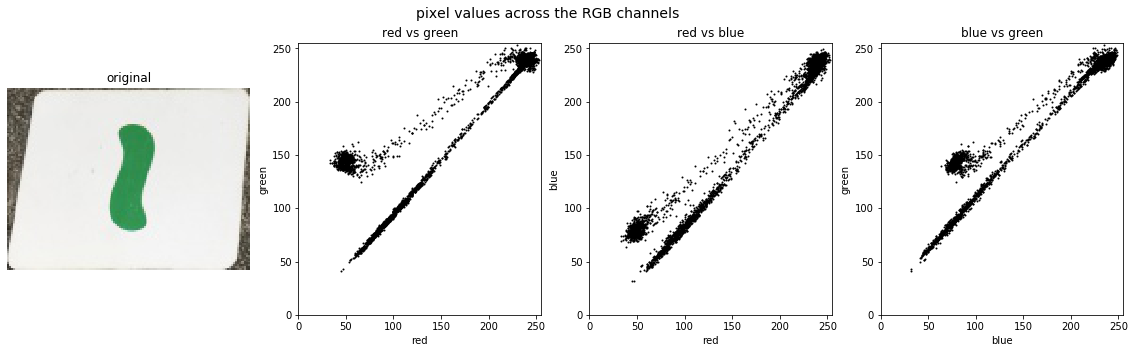

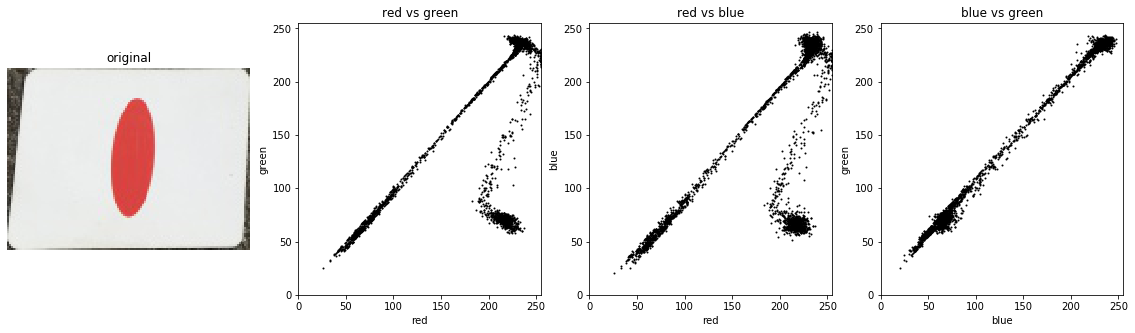

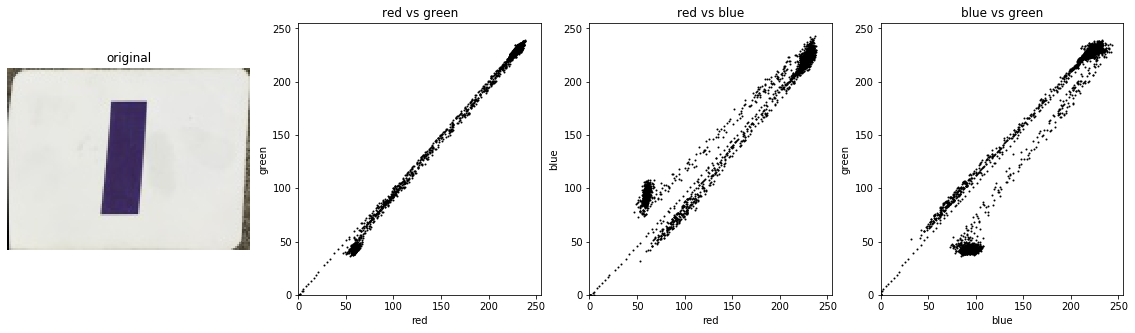

In [55]:
# Scatter plot for the RG, RB, and BG axes.
plot_scatter(img1, img_label="original", suptitle="pixel values across the RGB channels")
plot_scatter(img2, img_label="original")
plot_scatter(img3, img_label="original")

From these images we expect roughly three clusters:
* The largest should be for the white background pixels
* The colour of the symbol
* The darker non-card pixels in the background.

Let's use Kmeans clustering to see if we can find those clusters

### KMeans clustering of pixel values

In [56]:
def cluster_colours(img, n_clusters=10):
    # number of clusters
    kmeans = KMeans(n_clusters=n_clusters)

    # flatten image
    img_2d = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
    
    # fit image
    kmeans = kmeans.fit(img_2d)

    # centroid values
    centroids = kmeans.cluster_centers_

    # move pixel values to nearest cluster
    distances = []
    for centroid in centroids:
        distances.append(np.linalg.norm(img_2d - centroid, axis=1))
    distances = np.array(distances).T
    closed_centroid = np.argmin(distances, axis=1)
    img_reduced = centroids[closed_centroid]
    return img_reduced.reshape(96,128,3), centroids

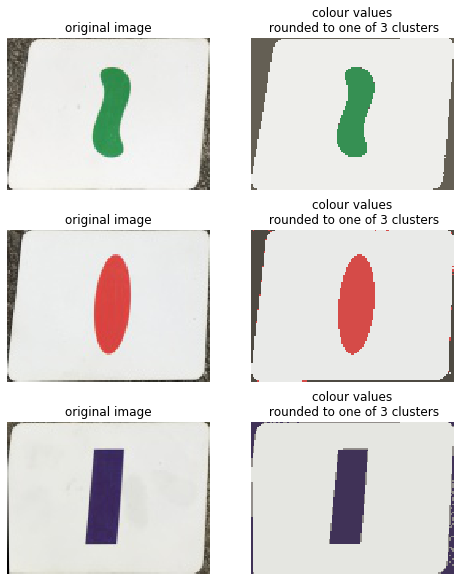

In [57]:
n_clusters = 3
img1_reduced, centroids1 = cluster_colours(img1, n_clusters=n_clusters)
img2_reduced, centroids2 = cluster_colours(img2, n_clusters=n_clusters)
img3_reduced, centroids3 = cluster_colours(img3, n_clusters=n_clusters)

original = [img1, img2, img3]
reduced = [img1_reduced, img2_reduced, img3_reduced]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))
for i, img in enumerate(original):
    axs[i, 0].set_title("original image")
    axs[i, 0].imshow(original[i]/255)
    axs[i, 0].axis('off')
    axs[i, 1].set_title(f"colour values\n rounded to one of {n_clusters} clusters")
    axs[i, 1].imshow(reduced[i]/255)    
    axs[i, 1].axis('off')    

In [86]:
def plot_scatter_centroids(img, img_label="", suptitle="", centroids=[]):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
    fig.suptitle(suptitle, fontsize=14)
    for i, colors in enumerate([("red", "green"), ("red", "blue"), ("blue", "green")]):
        color_channels = {'red': 0, 'green': 1, 'blue': 2}
        channels = (color_channels[colors[0]], color_channels[colors[1]])
        x = img[:,:,channels[0]].reshape(img.shape[0]*img.shape[1])
        y = img[:,:,channels[1]].reshape(img.shape[0]*img.shape[1])

        axs[0].set_title(img_label, fontsize=12)
        axs[0].imshow(img/255)        
        axs[i+1].set_title(f"{colors[0]} vs {colors[1]}")
        axs[i+1].set_xlim(0, 255)
        axs[i+1].set_ylim(0, 255)    
        axs[i+1].set_xlabel(colors[0])
        axs[i+1].set_ylabel(colors[1])
        axs[i+1].grid(True)
        axs[i+1].plot(x, y, linestyle="None", marker=".", color="k", alpha=0.3, markersize=10)
        
    for centroid in centroids:
        axs[1].plot(centroid[0], centroid[1], marker=".", color="red", markersize="20", alpha=1)
        axs[2].plot(centroid[0], centroid[2], marker=".", color="red", markersize="20", alpha=1)
        axs[3].plot(centroid[2], centroid[1], marker=".", color="red", markersize="20", alpha=1)

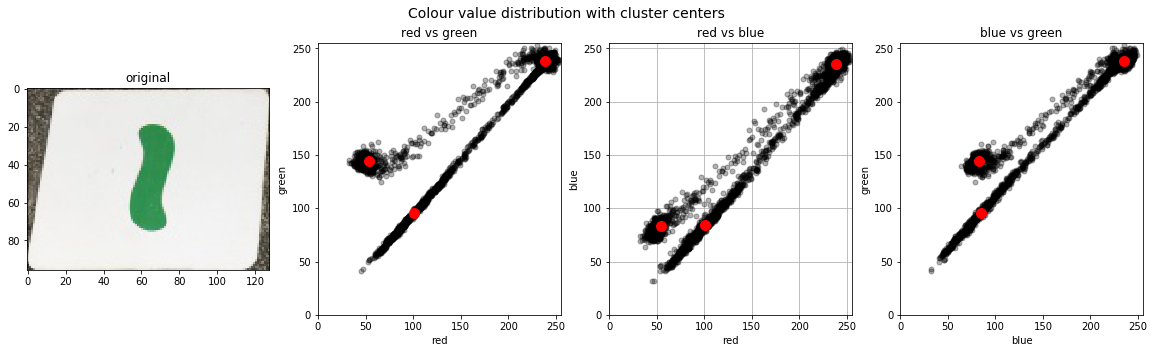

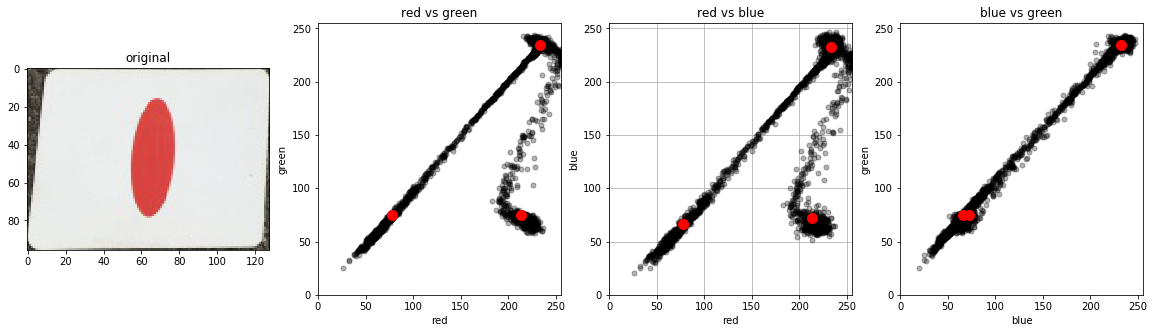

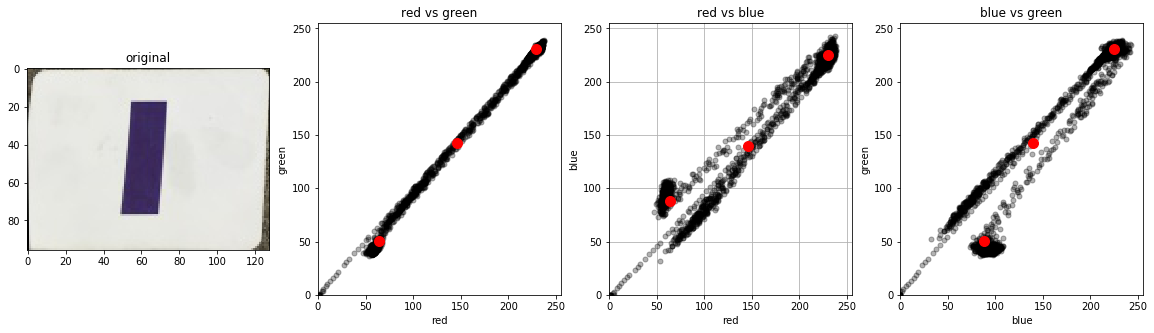

In [85]:
plot_scatter_centroids(img1, img_label="original", suptitle="Colour value distribution with cluster centers", centroids=centroids1)
plot_scatter_centroids(img2, img_label="original", suptitle="", centroids=centroids2)
plot_scatter_centroids(img3, img_label="original", suptitle="", centroids=centroids3)

### What is the effect of lighting changes?

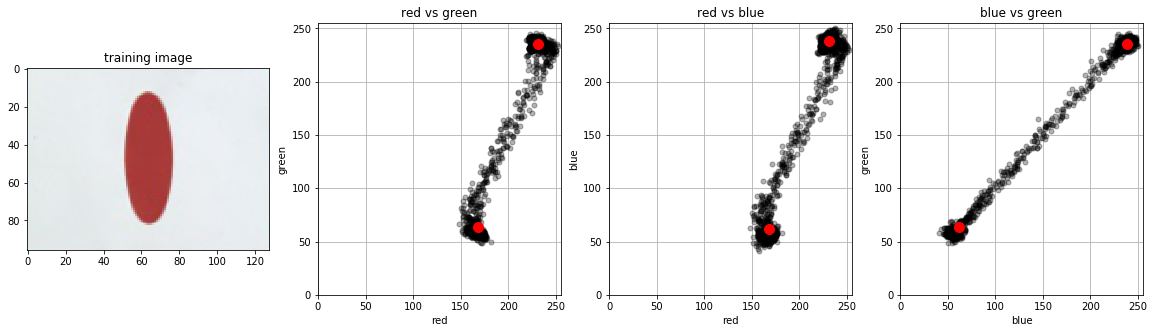

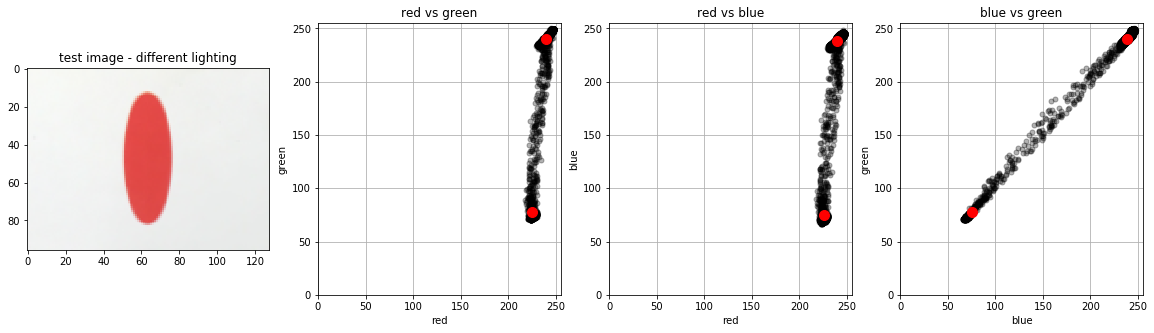

In [95]:
# Load training images of a single class
data_path = project_path / "src" / "set_cardgame" / "data" / "128x96"

img1a = read_image_with_cards(data_path / "train" / "0" / "2_red_round_solid_one.jpg", convert_to_rgb=True)
img1b = read_image_with_cards(data_path / "test" / "0" / "9_IMG_7802.JPG.png", convert_to_rgb=True)

# zoom the image with 5 pixels to remove the background pixels
img1a = zoom(img1a, p=5)
img1b = zoom(img1b, p=5)

n_clusters = 2
img1a_reduced, centroids1a = cluster_colours(img1a, n_clusters=n_clusters)
img1b_reduced, centroids1b = cluster_colours(img1b, n_clusters=n_clusters)

plot_scatter_centroids(img1a, img_label="training image", centroids=centroids1a)
plot_scatter_centroids(img1b, img_label="test image - different lighting", suptitle="", centroids=centroids1b)

The different lighting condition change the distribution of pixel values in the RGB space. 
I've zoomed in on the card a little to remove the background. Now there are two main clusters for the white background and the red colour. 
- The main effect for different lighting condition in the test image, is that the bottom (red) cluster is moved to to more intense values of red, and that the point-cloud rotates through the RGB space
- There is a slight visual change in the white background of the images, but the top (white) cluster doesn't seem to change a lot

### Fitting an affine transformation that approximates the lighting change

A lighting or photometric change can be seen as a geometric change of the colour values in RGB space. You can approximate these photometric changes using an affine transformation. This as a linear transformation where you can change translate, scale, rotate and shear objects. If you transform the point-cloud in RGB space using affine transformation you are in fact changing the lighting conditions.

Let's see if we can find the affine transformation that relates the two images above.

#### Fit transformation

Use least square optimization to find an affine transformation T that relates two images: `x' = T X` 

In [97]:
def objective(t, img1, img2):
    t = t.reshape(3, 3)
    return np.sum(np.abs(img2 - np.dot(img1, t)))


def find_transformation(img1, img2):
    # initial guess
    x0 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    
    # minimize objective
    solution = minimize(objective, x0, method='SLSQP', args=(img1, img2))
    
    # return solution as 3x3 matrix
    return solution.x.reshape(3, 3)


def affine_transformation_rgb(img, transformation_matrix):
    # reshape to 2d
    img_flat = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
    
    # apply transformation
    img_flat_new = np.dot(img_flat, transformation_matrix).reshape(img.shape)
    
    # scale back to uint8
    img_affine = cv2.convertScaleAbs(img_flat_new)

    return img_affine

In [108]:
# approximate transformation between the two images
T_approx = find_transformation(img1a, img1b)
print("Found affine transformation:\n", T_approx.round(2))

Found affine transformation:
 [[ 1.47  0.11  0.09]
 [ 1.27  1.9   1.79]
 [-1.67 -0.98 -0.85]]


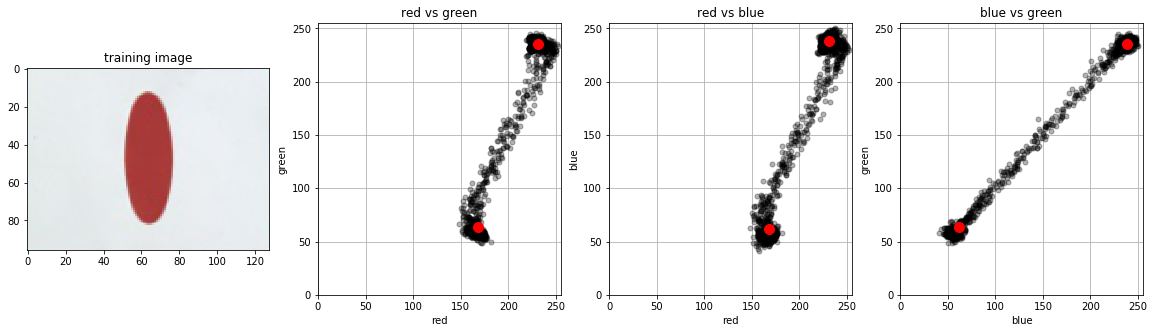

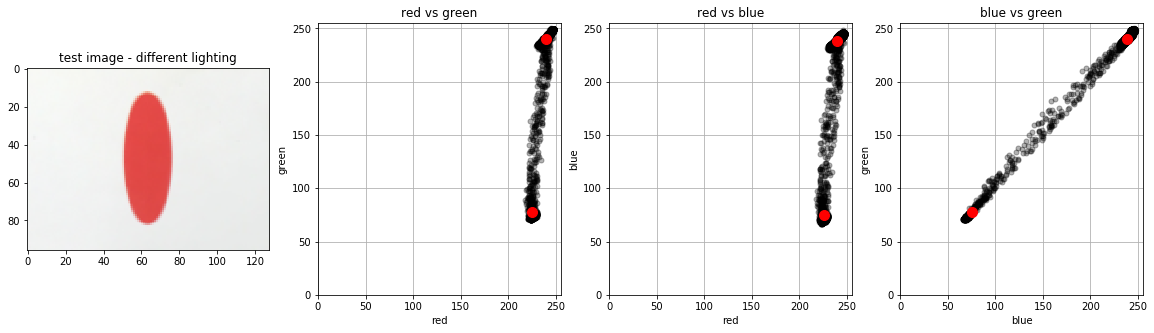

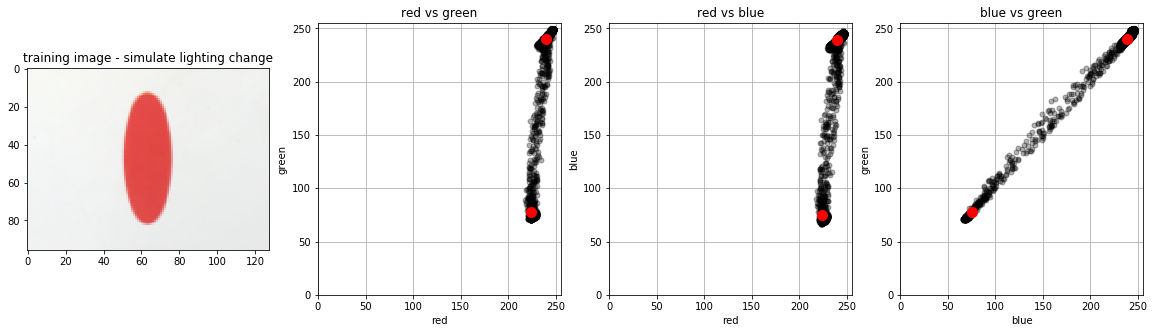

In [111]:
# apply found transformation to original image
img1a_approx = affine_transformation_rgb(img1a, T_approx)

n_clusters = 2
img1a_reduced, centroids1a = cluster_colours(img1a, n_clusters=n_clusters)
img1b_reduced, centroids1b = cluster_colours(img1b, n_clusters=n_clusters)
img1a_reduced_approx, centroids1a_approx = cluster_colours(img1a_approx, n_clusters=n_clusters)

plot_scatter_centroids(img1a, img_label="training image", centroids=centroids1a)
plot_scatter_centroids(img1b, img_label="test image - different lighting", suptitle="", centroids=centroids1b)
plot_scatter_centroids(img1b, img_label="training image - simulate lighting change", suptitle="", centroids=centroids1a_approx)

#### Conclusion

Using the fitted affine transformation we can transform the original training image to approximatly contain the lighting conditions that are present in the test image.

I find this interesting, because we now we are able to create collections of affine transformations that represent certain lighting conditions (ie. indoor, outdoor, office, nature, etc..) where we can sample from. This could be interesting for augmenting the training data with realistic photometric changes.

For the SET detection, I found that it was not really necessary to augment for these lighting changes, because for the (limited) test set, it classified all colours correctly.

But perhaps the classification fails for certain conditions, and this way of augmentation could help.